# Training and deploying a tabular model using Vertex AutoML.

![Training pipeline](../images/automl.png)

In [ ]:
%%bash
pip install --user google-cloud-aiplatform
pip install --user kfp
pip install --user google-cloud-pipeline-components
pip install --user google-cloud-bigquery-datatransfer

## Import the required packages

In [150]:
import os
import pprint
import pandas as pd
import tensorflow as tf
import time
from datetime import datetime
import csv

import matplotlib.pyplot as plt

import google.auth

from google.cloud import aiplatform as vertex_ai
from google.cloud.aiplatform_v1beta1 import types
from google.cloud import bigquery
from google.cloud import exceptions

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

from tensorflow_io import bigquery as tfio_bq


## Configure GCP settings

*Before running the notebook make sure to follow the repo's README file to install the pre-requisites and configure GCP authentication.*

In [18]:
creds, PROJECT = google.auth.default()
REGION = 'us-central1'
PREFIX = 'rtvw'            # <--- CHANGE THIS TO VARIABLE YOU SET UP DURING PREREQUISITES

STAGING_BUCKET = f'gs://{PREFIX}-{PROJECT}-bucket'
VERTEX_SA = f'training-sa@{PROJECT}.iam.gserviceaccount.com'

print(f"PROJECT = {PROJECT}")
print(f"STAGING_BUCKET = {STAGING_BUCKET}")
print(f"VERTEX_SA = {VERTEX_SA}")

PROJECT = rt-vertex-sandbox
STAGING_BUCKET = gs://rtvw-rt-vertex-sandbox-bucket
VERTEX_SA = training-sa@rt-vertex-sandbox.iam.gserviceaccount.com


## Preparing training data in BigQuery

### Explore Chicago Taxi dataset

In [20]:
%%bigquery data

SELECT 
    *
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
LIMIT 3

Downloading: 100%|██████████| 3/3 [00:01<00:00,  2.44rows/s]


In [21]:
data.head().T

,0,1,2
unique_key,afdb4903f8cbe066868d90c06b01449f58052462,a9488bef4cecbda3c212a6ebcd261ba26749df36,dcbbad2d636c999ef7fe5bbda536fb5ee3b84f8a
taxi_id,4399985da5ca143d850858bc197bf4a744366cfc19bb86...,68d140be0fa68d84f89f8ef45edca6eafd824b0bc30660...,dfdb89329a6bd26bb76e1d13bcac71b813d6bd3c9f3439...
trip_start_timestamp,2015-07-03 01:15:00+00:00,2015-10-04 01:30:00+00:00,2015-06-18 21:00:00+00:00
trip_end_timestamp,2015-07-03 01:15:00+00:00,2015-10-04 01:30:00+00:00,2015-06-18 21:00:00+00:00
trip_seconds,0,0,0
trip_miles,0.0,0.0,0.0
pickup_census_tract,NaN,NaN,NaN
dropoff_census_tract,NaN,NaN,NaN
pickup_community_area,NaN,NaN,NaN
dropoff_community_area,NaN,NaN,NaN


In [31]:
%%bigquery data

SELECT 
    CAST(EXTRACT(DAYOFWEEK FROM trip_start_timestamp) AS string) AS trip_dayofweek, 
    FORMAT_DATE('%A',cast(trip_start_timestamp as date)) AS trip_dayname,
    COUNT(*) as trip_count,
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE
    EXTRACT(YEAR FROM trip_start_timestamp) = 2020 
GROUP BY
    trip_dayofweek,
    trip_dayname
ORDER BY
    trip_dayofweek

Downloading: 100%|██████████| 7/7 [00:01<00:00,  6.43rows/s]


In [32]:
data

,trip_dayofweek,trip_dayname,trip_count
0,1,Sunday,334984
1,2,Monday,548213
2,3,Tuesday,599434
3,4,Wednesday,646244
4,5,Thursday,686346
5,6,Friday,667116
6,7,Saturday,406695


<AxesSubplot:xlabel='trip_dayname'>

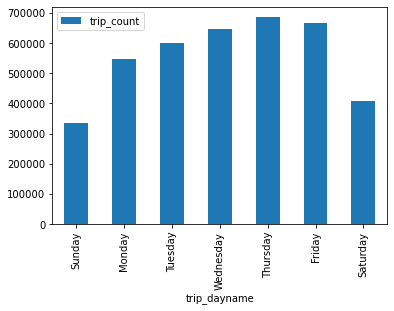

In [33]:
data.plot(kind='bar', x='trip_dayname', y='trip_count')

### Create data splits

In [25]:
BQ_DATASET_NAME = f'{PREFIX}_dataset' 
BQ_TABLE_NAME = 'features'
BQ_LOCATION = 'US'
SAMPLE_SIZE = 500000
YEAR = 2020

#### Create a BQ dataset to host the splits

In [28]:
client = bigquery.Client()

dataset_id = f'{PROJECT}.{BQ_DATASET_NAME}'
dataset = bigquery.Dataset(dataset_id)
dataset.location = BQ_LOCATION

try:
    dataset = client.create_dataset(dataset, timeout=30)
    print('Created dataset: ', dataset_id)
except exceptions.Conflict:
    print('Dataset {} already exists'.format(dataset_id))

Created dataset:  rt-vertex-sandbox.rtvw_dataset


#### Create a table with training features

In [34]:
sample_size = 1000000
year = 2020

sql_script_template = '''
CREATE OR REPLACE TABLE `@PROJECT.@DATASET.@TABLE` 
AS (
    WITH
      taxitrips AS (
      SELECT
        FORMAT_DATETIME('%Y-%d-%m', trip_start_timestamp) AS date,
        trip_start_timestamp,
        trip_seconds,
        trip_miles,
        payment_type,
        pickup_longitude,
        pickup_latitude,
        dropoff_longitude,
        dropoff_latitude,
        tips,
        fare
      FROM
        `bigquery-public-data.chicago_taxi_trips.taxi_trips`
      WHERE 1=1 
      AND pickup_longitude IS NOT NULL
      AND pickup_latitude IS NOT NULL
      AND dropoff_longitude IS NOT NULL
      AND dropoff_latitude IS NOT NULL
      AND trip_miles > 0
      AND trip_seconds > 0
      AND fare > 0
      AND EXTRACT(YEAR FROM trip_start_timestamp) = @YEAR
    )

    SELECT
      trip_start_timestamp,
      EXTRACT(MONTH from trip_start_timestamp) as trip_month,
      EXTRACT(DAY from trip_start_timestamp) as trip_day,
      EXTRACT(DAYOFWEEK from trip_start_timestamp) as trip_day_of_week,
      EXTRACT(HOUR from trip_start_timestamp) as trip_hour,
      trip_seconds,
      trip_miles,
      payment_type,
      ST_AsText(
          ST_SnapToGrid(ST_GeogPoint(pickup_longitude, pickup_latitude), 0.1)
      ) AS pickup_grid,
      ST_AsText(
          ST_SnapToGrid(ST_GeogPoint(dropoff_longitude, dropoff_latitude), 0.1)
      ) AS dropoff_grid,
      ST_Distance(
          ST_GeogPoint(pickup_longitude, pickup_latitude), 
          ST_GeogPoint(dropoff_longitude, dropoff_latitude)
      ) AS euclidean,
      IF((tips/fare >= 0.2), 1, 0) AS tip_bin,
      CASE (ABS(MOD(FARM_FINGERPRINT(date),10))) 
          WHEN 9 THEN 'TEST'
          WHEN 8 THEN 'VALIDATE'
          ELSE 'TRAIN' END AS data_split
    FROM
      taxitrips
    LIMIT @LIMIT
)
'''

sql_script = sql_script_template.replace(
    '@PROJECT', PROJECT).replace(
    '@DATASET', BQ_DATASET_NAME).replace(
    '@TABLE', BQ_TABLE_NAME).replace(
    '@YEAR', str(year)).replace(
    '@LIMIT', str(sample_size))

job = client.query(sql_script)
job.result()

#### Review the created features

In [35]:
sql_script = f'''
SELECT * EXCEPT (trip_start_timestamp)
FROM {PROJECT}.{BQ_DATASET_NAME}.{BQ_TABLE_NAME} 
'''
df = client.query(sql_script).result().to_dataframe()

In [36]:
df.head().T

,0,1,2,3,4
trip_month,6,6,6,6,6
trip_day,19,19,19,19,19
trip_day_of_week,6,6,6,6,6
trip_hour,0,0,0,0,0
trip_seconds,660,1200,241,480,358
trip_miles,1.1,4.1,0.77,1.5,1.1
payment_type,Cash,Cash,Cash,Cash,Prcard
pickup_grid,POINT(-87.7 41.9),POINT(-87.6 41.8),POINT(-87.7 41.9),POINT(-87.6 41.9),POINT(-87.7 42)
dropoff_grid,POINT(-87.6 41.9),POINT(-87.7 41.9),POINT(-87.7 41.9),POINT(-87.6 41.9),POINT(-87.7 42)
euclidean,3788.78383,2210.049904,0.0,0.0,0.0


## Creating a tabular dataset in Vertex

### Initialize Vertex AI SDK

In [38]:
vertex_ai.init(
    project=PROJECT,
    location=REGION,
    staging_bucket=STAGING_BUCKET
)

### Create a dataset and import data

In [39]:
display_name = 'Chicago taxi trips'
bq_source_uri = f'bq://{PROJECT}.{BQ_DATASET_NAME}.{BQ_TABLE_NAME}'

filter = f'display_name="{display_name}"'

dataset = vertex_ai.TabularDataset.list(filter=filter)
if not dataset:
    print("Creating a new dataset.")
    dataset = vertex_ai.TabularDataset.create(
        display_name=display_name, bq_source=bq_source_uri,
    )

    dataset.wait()
else:
    print("Using existing dataset: ", dataset[0].resource_name)
    dataset = vertex_ai.TabularDataset(dataset_name=dataset[0].resource_name)

Creating a new dataset.
INFO:google.cloud.aiplatform.datasets.dataset:Creating TabularDataset
INFO:google.cloud.aiplatform.datasets.dataset:Create TabularDataset backing LRO: projects/437422844431/locations/us-central1/datasets/4940950168527699968/operations/1243473159101874176
INFO:google.cloud.aiplatform.datasets.dataset:TabularDataset created. Resource name: projects/437422844431/locations/us-central1/datasets/4940950168527699968
INFO:google.cloud.aiplatform.datasets.dataset:To use this TabularDataset in another session:
INFO:google.cloud.aiplatform.datasets.dataset:ds = aiplatform.TabularDataset('projects/437422844431/locations/us-central1/datasets/4940950168527699968')


## Launching an AutoML training job

In [40]:
display_name = 'Chicago Taxi classifier training'
model_display_name = 'Chicago Taxi classifier'
target_column = 'tip_bin'
optimization_prediction_type = 'classification'
optimization_objective = 'maximize-recall-at-precision'
optimization_objective_precision_value = 0.7
split_column = 'data_split'
budget_milli_node_hours = 1000

column_transformations = [
    {'categorical': {'column_name': 'trip_month'}},
    {'categorical': {'column_name': 'trip_day'}},
    {'categorical': {'column_name': 'trip_day_of_week'}},
    {'categorical': {'column_name': 'trip_hour'}},
    {'categorical': {'column_name': 'payment_type'}},
    {'categorical': {'column_name': 'pickup_grid'}},
    {'categorical': {'column_name': 'dropoff_grid'}},
    {'numeric': {'column_name': 'trip_seconds'}},
    {'numeric': {'column_name': 'euclidean'}},
    {'numeric': {'column_name': 'trip_miles'}},
]

job = vertex_ai.AutoMLTabularTrainingJob(
    display_name=display_name,
    optimization_prediction_type=optimization_prediction_type,
    optimization_objective=optimization_objective,
    optimization_objective_precision_value=optimization_objective_precision_value,
    column_transformations=column_transformations,
)

model = job.run(
    dataset=dataset,
    target_column=target_column,
    budget_milli_node_hours=budget_milli_node_hours,
    model_display_name=model_display_name,
    predefined_split_column_name=split_column,
    sync=False
)

INFO:google.cloud.aiplatform.training_jobs:View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/1166049673442492416?project=437422844431
INFO:google.cloud.aiplatform.training_jobs:AutoMLTabularTrainingJob projects/437422844431/locations/us-central1/trainingPipelines/1166049673442492416 current state:
PipelineState.PIPELINE_STATE_PENDING
INFO:google.cloud.aiplatform.training_jobs:AutoMLTabularTrainingJob projects/437422844431/locations/us-central1/trainingPipelines/1166049673442492416 current state:
PipelineState.PIPELINE_STATE_PENDING
INFO:google.cloud.aiplatform.training_jobs:AutoMLTabularTrainingJob projects/437422844431/locations/us-central1/trainingPipelines/1166049673442492416 current state:
PipelineState.PIPELINE_STATE_RUNNING


In [80]:
print(f"Job Name: {job.display_name}")
print(f"Job Resource Name: {job.resource_name}\n")
print(f"Check training progress at {job._dashboard_uri()}")

Job Name: Chicago Taxi classifier training
Job Resource Name: projects/437422844431/locations/us-central1/trainingPipelines/1166049673442492416

Check training progress at https://console.cloud.google.com/ai/platform/locations/us-central1/training/1166049673442492416?project=437422844431
INFO:google.cloud.aiplatform.training_jobs:AutoMLTabularTrainingJob projects/437422844431/locations/us-central1/trainingPipelines/1166049673442492416 current state:
PipelineState.PIPELINE_STATE_RUNNING


In [ ]:
print(f"Job Name: {model.display_name}")

## Deploy Model


In [84]:
endpoint = model.deploy(machine_type="n1-standard-4", sync=False)

INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/437422844431/locations/us-central1/endpoints/7429021836882477056/operations/5488678757851987968


## Model Deployment

Now deploy the trained Vertex Model resource for batch and online prediction.

For online prediction, you:

- Create an Endpoint resource for deploying the Model resource to.
- Deploy the Model resource to the Endpoint resource.
- Make online prediction requests to the Endpoint resource.

For batch-prediction, you:

- Create a batch prediction job.
- The job service will provision resources for the batch prediction request.
- The results of the batch prediction request are returned to the caller.
- The job service will unprovision the resoures for the batch prediction request.

### Predict on Endpoint - Online Prediction

In [85]:
job.state

<PipelineState.PIPELINE_STATE_SUCCEEDED: 4>

In [86]:
endpoint.wait()

INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/437422844431/locations/us-central1/endpoints/7429021836882477056
INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:
INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/437422844431/locations/us-central1/endpoints/7429021836882477056')
INFO:google.cloud.aiplatform.models:Deploying model to Endpoint : projects/437422844431/locations/us-central1/endpoints/7429021836882477056
INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/437422844431/locations/us-central1/endpoints/7429021836882477056/operations/7794521767065681920
INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/437422844431/locations/us-central1/endpoints/7429021836882477056


In [98]:
test_instances = [  
    
    {
        "dropoff_grid": "POINT(-87.6 41.9)",
        "euclidean": 2064.2696,
        "payment_type": "Credit Card",
        "pickup_grid": "POINT(-87.6 41.9)",
        "trip_miles": 1.37,
        "trip_day": "12",
        "trip_hour": "16",
        "trip_month": "2",
        "trip_day_of_week": "4",
        "trip_seconds": "555"
    }
]

predictions = automl_endpoint.predict(instances=test_instances)

In [93]:
predictions

Prediction(predictions=[{'scores': [0.4606399536132812, 0.5393600463867188], 'classes': ['0', '1']}], deployed_model_id='365759140049453056', explanations=None)

In [95]:
predictions = automl_endpoint.explain(instances=test_instances)
predictions

Prediction(predictions=[{'classes': ['0', '1'], 'scores': [0.4606399536132812, 0.5393600463867188]}], deployed_model_id='365759140049453056', explanations=[attributions {
  baseline_output_value: 0.5400587916374207
  instance_output_value: 0.5393600463867188
  feature_attributions {
    struct_value {
      fields {
        key: "dropoff_grid"
        value {
          number_value: 0.0
        }
      }
      fields {
        key: "euclidean"
        value {
          number_value: -1.940876245498657e-06
        }
      }
      fields {
        key: "payment_type"
        value {
          number_value: 0.0
        }
      }
      fields {
        key: "pickup_grid"
        value {
          number_value: 0.0
        }
      }
      fields {
        key: "trip_day"
        value {
          number_value: -0.00120052695274353
        }
      }
      fields {
        key: "trip_day_of_week"
        value {
          number_value: 0.0002503432333469391
        }
      }
      fields {
  

### Batch Prediction Job

Now do a batch prediction to your deployed model.

#### Make test items

In [194]:
sql_script = f'''
SELECT trip_month, trip_day, trip_day_of_week, trip_hour, payment_type, pickup_grid, dropoff_grid, trip_seconds, euclidean, trip_miles
FROM {PROJECT}.{BQ_DATASET_NAME}.{BQ_TABLE_NAME} 
LIMIT 1000
'''

dtypes = {
    'dropoff_grid': str,
    'euclidean': 'float64',
    'trip_month': str,
    'trip_day': str,
    'trip_day_of_week': str,
    'trip_hour': str,
    'payment_type': str,
    'pickup_grid': str,
    'trip_seconds': str,
    'trip_miles': 'float64'
}

df_test_batch = client.query(sql_script).result().to_dataframe(dtypes=dtypes)

In [195]:
df_test_batch.head()

,trip_month,trip_day,trip_day_of_week,trip_hour,payment_type,pickup_grid,dropoff_grid,trip_seconds,euclidean,trip_miles
0,6,19,6,0,Cash,POINT(-87.7 41.9),POINT(-87.6 41.9),660,3788.783830,1.10
1,6,19,6,0,Cash,POINT(-87.6 41.8),POINT(-87.7 41.9),1200,2210.049904,4.10
2,6,19,6,0,Cash,POINT(-87.7 41.9),POINT(-87.7 41.9),241,0.000000,0.77
3,6,19,6,0,Cash,POINT(-87.6 41.9),POINT(-87.6 41.9),480,0.000000,1.50
4,6,19,6,0,Prcard,POINT(-87.7 42),POINT(-87.7 42),358,0.000000,1.10


In [196]:
df_test_batch.dtypes

trip_month           object
trip_day             object
trip_day_of_week     object
trip_hour            object
payment_type         object
pickup_grid          object
dropoff_grid         object
trip_seconds         object
euclidean           float64
trip_miles          float64
dtype: object

In [197]:
out_file_name = "bq_export_features_test.csv"
gcs_batch_request_csv = f'{STAGING_BUCKET}/test/batch/{out_file_name}'
df_test_batch.to_csv(f'{STAGING_BUCKET}/test/batch/bq_export_features_test.csv',
                     header=True, 
                     index=False,
                     quoting=csv.QUOTE_NONNUMERIC,
                     escapechar="\\",
                     doublequote=False
                    )

In [198]:
!gsutil cat $gcs_batch_request_csv  | head

"trip_month","trip_day","trip_day_of_week","trip_hour","payment_type","pickup_grid","dropoff_grid","trip_seconds","euclidean","trip_miles"
"6","19","6","0","Cash","POINT(-87.7 41.9)","POINT(-87.6 41.9)","660",3788.7838301551124,1.1
"6","19","6","0","Cash","POINT(-87.6 41.8)","POINT(-87.7 41.9)","1200",2210.049904442757,4.1
"6","19","6","0","Cash","POINT(-87.7 41.9)","POINT(-87.7 41.9)","241",0.0,0.77
"6","19","6","0","Cash","POINT(-87.6 41.9)","POINT(-87.6 41.9)","480",0.0,1.5
"6","19","6","0","Prcard","POINT(-87.7 42)","POINT(-87.7 42)","358",0.0,1.1
"6","19","6","0","Unknown","POINT(-87.7 41.9)","POINT(-87.6 41.8)","900",10666.168994769989,0.4
"6","19","6","0","Prcard","POINT(-87.7 41.8)","POINT(-87.6 41.7)","1780",12414.729032476023,9.64
"6","19","6","0","Credit Card","POINT(-87.6 41.9)","POINT(-87.6 41.9)","383",0.0,0.8
"6","19","6","0","Cash","POINT(-87.7 42)","POINT(-87.7 42)","240",2406.0409792388746,0.9


#### Make the batch prediction request

Now that your Model resource is trained, you can make a batch prediction by invoking the batch_request() method, with the following parameters:

- `job_display_name`: The human readable name for the batch prediction job.
- `gcs_source`: A list of one or more batch request input files.
- `gcs_destination_prefix`: The Cloud Storage location for storing the batch prediction resuls.
- `sync`: If set to True, the call will block while waiting for the asynchronous batch job to complete.

In [202]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

In [203]:
batch_predict_job = model.batch_predict(
    job_display_name=f"{model_display_name}-batch-{TIMESTAMP}",
    gcs_source=gcs_batch_request_csv,
    instances_format="csv",
    gcs_destination_prefix=f'{STAGING_BUCKET}/test/batch_results/',
    predictions_format="csv",
    sync=False
)

print(batch_predict_job)

INFO:google.cloud.aiplatform.jobs:Creating BatchPredictionJob
<google.cloud.aiplatform.jobs.BatchPredictionJob object at 0x7fe580503c50> is waiting for upstream dependencies to complete.
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob created. Resource name: projects/437422844431/locations/us-central1/batchPredictionJobs/9044815746550464512
INFO:google.cloud.aiplatform.jobs:To use this BatchPredictionJob in another session:
INFO:google.cloud.aiplatform.jobs:bpj = aiplatform.BatchPredictionJob('projects/437422844431/locations/us-central1/batchPredictionJobs/9044815746550464512')
INFO:google.cloud.aiplatform.jobs:View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/batch-predictions/9044815746550464512?project=437422844431


#### Wait for completion of batch prediction job
Next, wait for the batch job to complete.

In [ ]:
batch_predict_job.wait()

INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/437422844431/locations/us-central1/batchPredictionJobs/9044815746550464512 current state:
JobState.JOB_STATE_RUNNING
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/437422844431/locations/us-central1/batchPredictionJobs/9044815746550464512 current state:
JobState.JOB_STATE_RUNNING
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/437422844431/locations/us-central1/batchPredictionJobs/9044815746550464512 current state:
JobState.JOB_STATE_RUNNING
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/437422844431/locations/us-central1/batchPredictionJobs/9044815746550464512 current state:
JobState.JOB_STATE_RUNNING


#### Get the predictions
Next, get the results from the completed batch prediction job.

The results are written to the Cloud Storage output bucket you specified in the batch prediction request. You call the method iter_outputs() to get a list of each Cloud Storage file generated with the results. Each file contains one or more prediction requests in a JSON format:

- `content`: The prediction request.
- `prediction`: The prediction response.
    - `ids`: The internal assigned unique identifiers for each prediction request.
    - `displayNames`: The class names for each class label.
    - `confidences`: The predicted confidence, between 0 and 1, per class label.

In [122]:
bp_iter_outputs = batch_predict_job.iter_outputs()

prediction_results = list()
for blob in bp_iter_outputs:
    if blob.name.split("/")[-1].startswith("prediction"):
        prediction_results.append(blob.name)

In [ ]:
tags = list()
for prediction_result in prediction_results:
    gfile_name = f"gs://{bp_iter_outputs.bucket.name}/{prediction_result}"
    with tf.io.gfile.GFile(name=gfile_name, mode="r") as gfile:
        for line in gfile.readlines():
            print(line)

## Clean up

### Undeploy Models
When you are done doing predictions, you undeploy the Model resource from the Endpoint resouce. This deprovisions all compute resources and ends billing for the deployed model.

In [ ]:
endpoint.list_models()

In [ ]:
endpoint.undeploy_all()

### Delete Endpoint

In [ ]:
endpoint.delete()

### Delete Model

In [ ]:
model.delete()